# Assignment 6: Clustering and Topic Modeling

In this assignment, we are going to look into clustering and similar techniques to get an overview of the types and topics of documents in our collection. Specifically, we will apply topic modeling with [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) and use the results to extract and visualize clusters of related documents.

## Code from previous assignments

First, we run some code copied from the previous assignments:

In [1]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [2]:
Ids_file = 'data/allergy_Ids.pkl.bz2'
Summaries_file = 'data/allergy_Summaries.pkl.bz2'
Abstracts_file = 'data/allergy_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [3]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

We will use a slightly modified tokenization function, which ignores all special characters:

In [4]:
chars = set('abcdefghijklmnopqrstuvwxyz ')

def tokenize(text):
    return ''.join(filter(chars.__contains__, text)).split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

And then we create our inverted index as before:

In [5]:
inverted_index = defaultdict(set)

for (id, abstract) in Abstracts.items():
    for term in preprocess(tokenize(abstract)):
        inverted_index[term].add(id)

## Data preparation

To perform topic modeling on our data, we need a matrix representation, and as a first step we have to put our documents into a fixed sequence. We can simply create a list for that:

In [6]:
doc_list = [id for (id, abstract) in Abstracts.items()]

print(len(doc_list))

73679


Next, we need to do the same for the terms. To ensure that the matrix doesn't get too large, we will restrict ourselves here to the terms that appear in at least 100 documents, but in not more than 10% of all the documents. This gives us about 4000 terms to work with:

In [7]:
short_term_list = [
    t for t in list(inverted_index.keys())
    if (len(inverted_index[t]) > 100 and len(inverted_index[t]) < 0.1*len(doc_list))
]

print(len(short_term_list))

3913


Now that we have defined a fixed sequence for documents as well as terms, we can use this to create a term-document incidence matrix of boolean values denoting whether a given term appears in a given document. The creation of this matrix might take a few minutes (and requires the [NumPy](http://www.numpy.org/) package):

In [8]:
! pip install --user numpy

In [9]:
import numpy as np

doc_term_matrix = np.zeros((len(doc_list), len(short_term_list)), np.bool_)

for d in range(0,len(doc_list)):
    for i in range(0,len(short_term_list)):
        if (doc_list[d] in inverted_index[short_term_list[i]]):
            doc_term_matrix[d,i] = True

To find out, for example, whether the word "milk" is contained in the article with identifier 17935766, we first have to look up their position in our lists `short_term_list` and `doc_list`, respectively (the code below is not very efficient, but this is not our concern here):

In [10]:
termid = short_term_list.index('milk')
print(termid)

docid = doc_list.index(17935766)
print(docid)

251
30654


Knowing these positions, we can look up the value in our matrix, to find out that the given word is indeed mentioned in the given paper:

In [11]:
doc_term_matrix[docid,termid]

True

Now we are ready to use this matrix to calculate topic for our documents.

## Topic Modeling

We are going to use the [lda](https://pypi.python.org/pypi/lda) package for this assignment, which you might have to download and install first.

In [12]:
! pip install --user lda

In [13]:
import lda

First, we have to specify how many topics we want to get and how many iterations the algorithm is supposed to run (the more iterations the more precise the result). We will first have a look at the result for 10 topics, and we store this configuration in a variable called `model10`. 50 iterations is a good value for our purposes here. Furthermore, we specify `random_state=1`, which will ensure that we will get exactly the same result when running the same code several times:

In [14]:
model10 = lda.LDA(n_topics=10, n_iter=50, random_state=1)

Next, we can give it our matrix to calcuate the topics and how they connect to our documents. This might again take a few minutes:

In [15]:
model10.fit(doc_term_matrix);

INFO:lda:n_documents: 73679
INFO:lda:vocab_size: 3913
INFO:lda:n_words: 2352143
INFO:lda:n_topics: 10
INFO:lda:n_iter: 50
INFO:lda:<0> log likelihood: -24528973
INFO:lda:<10> log likelihood: -20608915
INFO:lda:<20> log likelihood: -19486573
INFO:lda:<30> log likelihood: -19198749
INFO:lda:<40> log likelihood: -19078177
INFO:lda:<49> log likelihood: -19018117


The result can be found in `model10.topic_word_` and `model10.doc_topic_`, which show the connections of topics to the words and documents, respectively.

The following function prints out the 8 most important words per topic:

In [16]:
def show_topics(m):
    for i, topic_dist in enumerate(m.topic_word_):
        topic_words = np.array(short_term_list)[np.argsort(topic_dist)][:-9:-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))

show_topics(model10)

Topic 0: chronic such most other associated diseases therapy syndrome
Topic 1: milk children foods cows infants diet allergies ood
Topic 2: allergens test skin tests allergen specific positive diagnosis
Topic 3: use review management immunotherapy llergy health their research
Topic 4: prevalence risk children factors associated studies among exposure
Topic 5: had children than symptoms age group significantly significant
Topic 6: allergen protein major allergens proteins we using binding
Topic 7: after results than showed compared significantly effect levels
Topic 8: contact patient reaction case skin after who cases
Topic 9: cells immune role cell responses diseases we inflammation


`doc_topic_` is a matrix where each row stands for one of our documents and each column represents one of the 10 topics. Let's have a look at the values for a particular document, say the one at position 1000:

In [17]:
doc_topic10 = model10.doc_topic_
doc_topic10[1000,:]

array([0.0125, 0.1375, 0.0125, 0.6375, 0.1375, 0.0125, 0.0125, 0.0125,
       0.0125, 0.0125])

You might be getting different values, as topic modeling is not deterministic, but all values are non-negative (typically larger than zero). Moreover, there is often one topic that has a clearly higher value than the others. We can find out about the highest value with the function `np.argmax`:

In [18]:
np.argmax(doc_topic10[1000,:])

3

We can also verify that the sum of all the values corresponds to 1 (possibly with a bit of a rounding error):

In [19]:
sum(doc_topic10[1000,:])

1.0

To get a feeling of the data, let's make a [scatter plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) of how the documents are distributed with respect to topics 0 and 1:

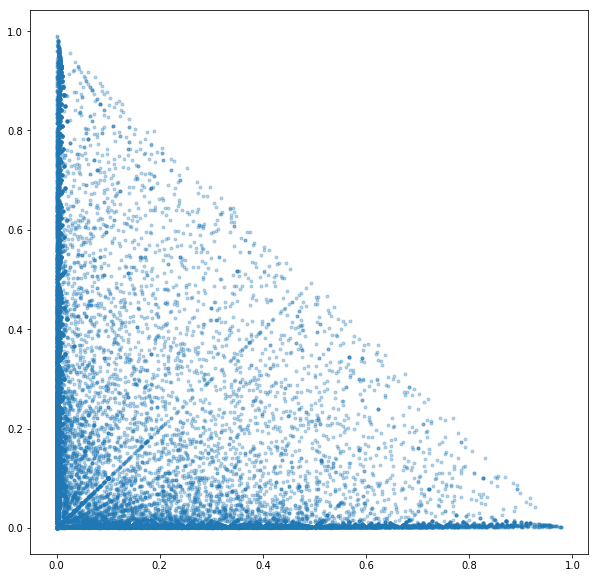

In [20]:
# Make the plots a bit larger:
plt.rcParams["figure.figsize"] = [10, 10]

plt.scatter(doc_topic10[:,0], doc_topic10[:,1], marker='.', alpha=0.3);

We see that most documents are close to the zero value for topic 0 or topic 1 or both. This is not surprising, because we have 10 topics but are only showing two of them. Most documents have their highest values on one of the other eight topics, and therefore show up at the edges of this plot.

We also see a triangle shaped distribution. This is also not surprising: for any given document, all values add up to 1, and therefore no document can have a value of more than 0.5 for more than one topic at the same time. If we know the values for 9 out of the 10 topics, we can in fact calculate the value for the tenth topic too. In other words, the last topic column doesn't contain extra information.

For nicer visualization, we can use the `color` argument to specify a color. We can give it also a list of values to declare different colors for the different data points. Here we just draw the first half of the points red, and the second half green:

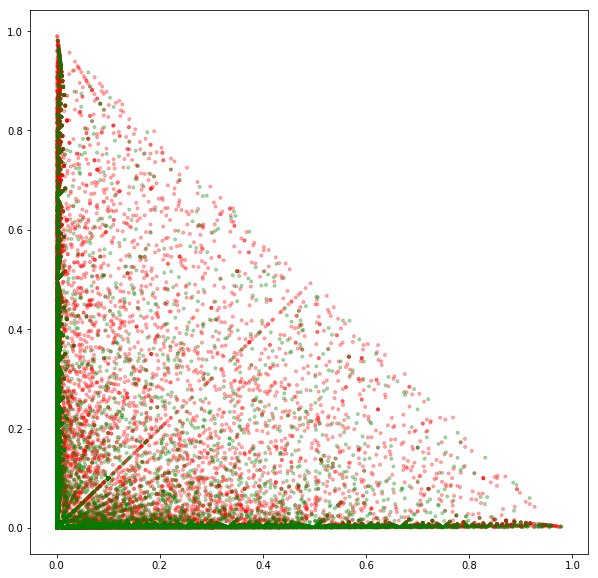

In [21]:
s = len(doc_topic10[:,0])
red_n = int(s/2)
green_n = s - red_n
color_list = ['r'] * red_n + ['g'] * green_n

plt.scatter(doc_topic10[:,0], doc_topic10[:,1], marker='.', alpha=0.3, color=color_list);

The above is a very random use of colors, because they don't map to anything sensible in our data, but we will have a more meaningful application below.

We can also call `plt.scatter` several times to overlay multiple plots. We can use that, for example, to highlight a selected paper, such as 17935766:

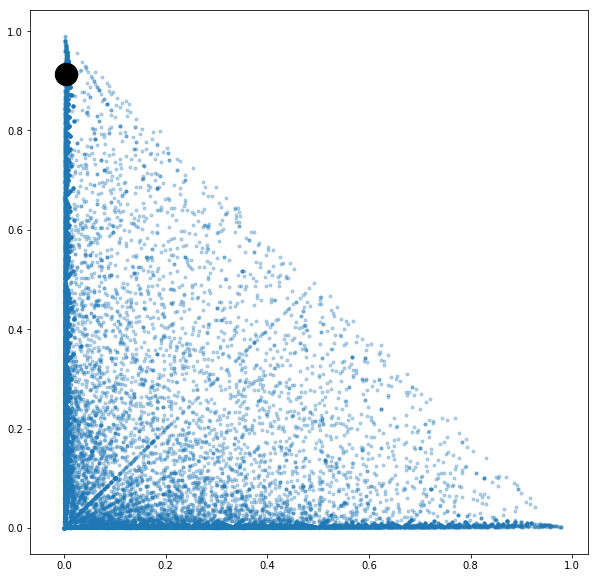

In [22]:
plt.scatter(doc_topic10[:,0], doc_topic10[:,1], marker='.', alpha=0.3)

i = doc_list.index(17935766)
plt.scatter(doc_topic10[i,0], doc_topic10[i,1], s=500, marker='o', color='k');

In the tasks below, you are now asked to build upon this and provide a better 2-dimensional visualization of the document topic space.

----------

# Tasks

**Your name:** Dragos Pop

### Task 1

The problem with the above plots was that they only covered 2 out of 10 topics. To get a better 2-dimensional "landscape" of the topics in our documents, we want to calculate another topic model with just 3 instead of 10 topics. As we have seen above, the last topic doesn't add additional information, and therefore we can optimally plot 3 topics on a 2-dimensional space.

Initialize a new topic model configured to calculate 3 topics and save it in a variable called `model3` (use otherwise the same parameter values as above). Feed the same matrix as above as input to this model to calculate the topic mappings. Use then the `show_topics` function defined above to output a summary of the generated topics.

In [23]:
model3 = lda.LDA(n_topics=3, n_iter=50, random_state=1)
model3.fit(doc_term_matrix);
show_topics(model3)

INFO:lda:n_documents: 73679
INFO:lda:vocab_size: 3913
INFO:lda:n_words: 2352143
INFO:lda:n_topics: 3
INFO:lda:n_iter: 50
INFO:lda:<0> log likelihood: -20844224
INFO:lda:<10> log likelihood: -19287854
INFO:lda:<20> log likelihood: -18502083
INFO:lda:<30> log likelihood: -18403163
INFO:lda:<40> log likelihood: -18392424
INFO:lda:<49> log likelihood: -18392476


Topic 0: skin test used allergens tests after positive reaction
Topic 1: children risk symptoms prevalence years factors o studies
Topic 2: cells immune cell role we response diseases responses


### Task 2

Now create a scatter plot of the form introduced above to visualize your new topic model created in Task 1. Explain what the three corners of the triangle in your plot stand for with respect to the three topics.

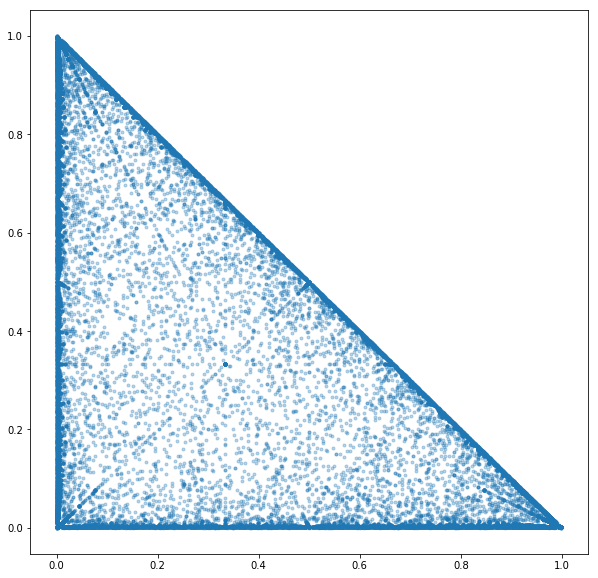

In [24]:
doc_topic3 = model3.doc_topic_
plt.scatter(doc_topic3[:,0], doc_topic3[:,1], marker='.', alpha=0.3);

**Answer:** The bottom-right corner of the triangle gathers together the documents that are mainly composed of Topic 0. Respectively, the Topic 1 texts pile up in the top-left corner, while in the bottom-left corner, there are the papers that are mostly formed of Topic 2. In other words, the closer the document is to one of the three corners, the larger the proportion of the topic.

### Task 3

The results from tasks 1 and 2 give us a landscape to position papers in, but we would also like to use colors to indicate better what the different areas mean. For that, we go back to the topic model we defined first with 10 topics. We still have the result stored in the variables `model10` and `doc_topic10`. To understand these 10 topics a bit better, write a function `show_top_papers_on_topic` that takes a topic number from 0 to 9, and outputs the top 3 papers with the highest score on the given topic. Use `display_summary` to display the results and demonstrate your function by calling it to show the top 3 papers for topic 5.

Look at the top 3 papers for each topic and also consult the results for `show_topics(model10)` above to understand a bit better what these topics stand for. Based on this, create a list `topic_labels` with 10 string elements that give a short human-readable label for each of the 10 topics (for example 'side effects' or 'clinical studies').

In [25]:
doc_indexes = range(len(doc_list))

def show_top_papers_on_topic(topic): 
     for doc_index in sorted(doc_indexes, key = lambda score: doc_topic10[score, topic], reverse = True)[:3]:
        display_summary(doc_list[doc_index], show_abstract=True)

show_top_papers_on_topic(5)

topic_labels = ["disease studies", "children food allergies", "allergens studies", "immunotherapy researches",
                "respiratory allergies", "breathing disorders", "protein studies", "treatment effects",
                "skin allergies", "cell disorders"]

### Task 4

Now we can combine our model with 3 topics with the one with 10 topics: We will use the 3-topic one to define the position of the documents in 2-dimensional space, as in tasks 1 and 2, and we will use the 10-topic one to define a color scheme and attach topic labels to these colors. So we end up with 2 dimensions and 10 colors.

For that, we first import some more packages and define ten colors (so we can access the colors with `colors[0]`, `colors[1]`, etc.). You don't need to change anything in this code block:

In [26]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 10))

Now, create a list called `clusters` that has the same size and ordering as `doc_list` and specifies which cluster the given document belongs to. For that, we use our topic model with 10 topics (`model10`) in the following way: all documents that have their highest value for topic 0 belong to cluster 0; those with the highest value for topic 1 go to cluster 1; etc. (Hint: you can use the `np.argmax` function as shown above to find the position with the highest value in a list.)

Then copy the code for the scatter plot from task 2, but use the `c` argument to plot each document in the color corresponding to its cluster (hint: you can create a list of colors first, where the first element stands for the color of the first document, the second for the color of the second document, and so on). You can experiment with the values for `marker`, `alpha`, and `s` to improve the visual appearance.

In the end you can run the command below to add a legend to the plot, using the colors and labels as defined above.

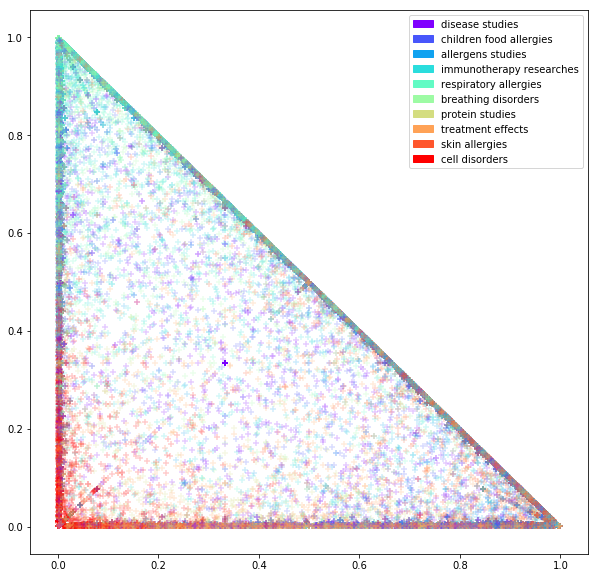

In [27]:
clusters = []
for i in range(len(doc_list)):
    clusters.append(np.argmax(doc_topic10[i, :]))

colorlist = colors[clusters]
plt.scatter(doc_topic3[:,0], doc_topic3[:,1], marker='+', alpha=0.2, c = colorlist);
plt.legend(handles=[mpatches.Patch(color=colors[i], label=topic_labels[i]) for i in range(0,10)]);

### Task 5

Finally, you should use the results from above to provide a function `show_paper` that takes a document identifier (like 16310526) and displays a summary of the paper (using `display_summary`) and shows its position in the "landscape" created above. For that, copy the code from Task 4 and additionally show a thick black dot to indicate the position of the given document in that landscape (see the code in the instructions above on how to show such a dot). Demonstrate your function by showing such a graphical summary for paper 16310526.

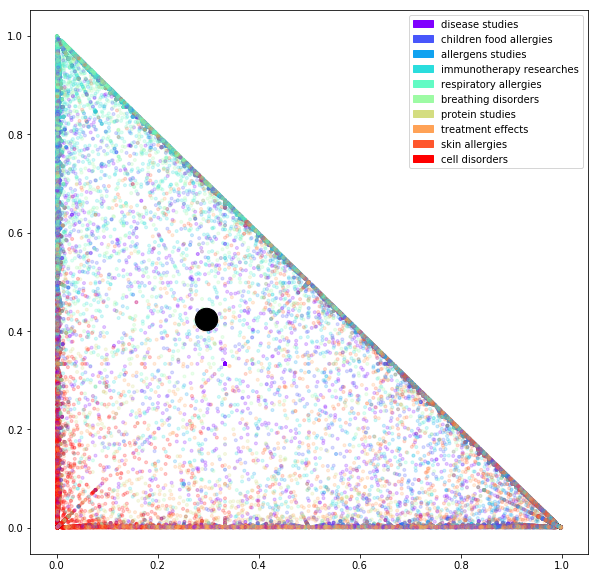

In [28]:
def show_paper(doc_id): 
    display_summary(doc_id, show_abstract = True)
    
    i = doc_list.index(doc_id)
    plt.scatter(doc_topic3[:,0], doc_topic3[:,1], marker='.', alpha=0.2, c = colorlist);
    plt.scatter(doc_topic3[i,0], doc_topic3[i,1], s=500, marker='o', color='k');
    plt.legend(handles=[mpatches.Patch(color=colors[i], label=topic_labels[i]) for i in range(0,10)]);
    
show_paper(16310526)

# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done individually and group submissions are **not allowed**.